<a href="https://colab.research.google.com/github/AilingLiu/Recommendation_Model_On_Vehicle_Recall/blob/master/Recommendation_Model_On_Vehicle_Recall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

This project is a take-home-test as part of interview process. The data is provided by the company, and can be downloaded from my google drive following the notebook instruction.

**Project Introduction**

A car manufacturer is deciding whether a specific vehicle should be recalled; there appears to be a problem with some brake components, but it might be related to multiple variables. 

The stakeholder wants you to build something that allows them to recommend a recall based on the historical decision data provided.

Ideally, the car company released the following model last summer and real-world feedback suggests that the model might be worthy of a recall.

*Created by*:
Ailing Liu. email:
ailingliu88@hotmail.com

# Set Up

In [2]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= '0.2'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import statsmodels.formula.api as smf
import os
import urllib


REQUIREMENT_FILE = 'https://raw.githubusercontent.com/AilingLiu/Recommendation_Model_On_Vehicle_Recall/master/requirements.txt' #stored on github
#REQUIREMENT_FILE = 'https://drive.google.com/u/0/uc?id=151lpB4jCHNQJiiZabmm_JQTczehYuq1O&export=download' #alternative, stored on gdrive

REQ_NAME = 'requirements.txt'

def fetch_file(file_url=REQUIREMENT_FILE, output_name=REQ_NAME):
  #gdown.download(req_file, output_name, quiet=False)
  print('Downloading')
  urllib.request.urlretrieve(file_url, output_name) 
  print('Complete.')

fetch_file()

Downloading
Complete.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pip install -r requirements.txt

In [0]:
# where to save figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'CAR'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, 'IMAGES')
if not os.path.isdir(IMAGES_PATH):
  os.makedirs(IMAGES_PATH)

# saving figures helper
def save_fig(figure_name, path=IMAGES_PATH, dpi=300, tight_layout=True, format='png'):
  figure_path=os.path.join(path, figure_name+'.'+format)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(figure_path, dpi=dpi, format=format)

# where to save data
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, 'DATASETS')
if not os.path.isdir(DATA_PATH):
  os.makedirs(DATA_PATH)

# where to save model pickle
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, 'MODELS')
if not os.path.isdir(MODEL_PATH):
  os.makedirs(MODEL_PATH)

import joblib
def save_model(model_obj, model_name, path=MODEL_PATH):
  model_path = os.path.join(path, model_name+'.pkl')
  joblib.dump(model_obj, model_path)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Load Data

In [5]:
CAR_URL = 'https://raw.githubusercontent.com/AilingLiu/Recommendation_Model_On_Vehicle_Recall/master/Recall_Data.csv' #stored on github
#CAR_URL = 'https://drive.google.com/u/0/uc?id=1gN_rtHd2opL3WOP9ra3vEdzdtJo-2EHh&export=download' #alternative, stored on gdrive

OUTPUT_NAME = os.path.join(DATA_PATH, 'recall.csv')

def load_data(file_name=OUTPUT_NAME):
  column_names = ['model_year', 'fuel', 'wheel', 'power_hp', 'transmission', 'body', 'variant', 'quantity_sold', 'recall_result']
  return pd.read_csv(file_name, header=0, names=column_names)

fetch_file(CAR_URL, OUTPUT_NAME)
car = load_data()
car.head()

Downloading
Complete.


,model_year,fuel,wheel,power_hp,transmission,body,variant,quantity_sold,recall_result
0,2002,diesel,steel,100,semi-automatic,hatchback,Base,2641,recall
1,2010,petrol,alloy,250,automatic,wagon,GT,1349,recall
2,1992,diesel,steel,125,semi-automatic,saloon,S,7980,do not recall
3,2010,petrol,alloy,250,semi-automatic,wagon,Base,1135,do not recall
4,2005,diesel,steel,300,automatic,saloon,Base,2089,recall


# Exploratory Data Analysis

In [0]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model_year     100 non-null    int64 
 1   fuel           100 non-null    object
 2   wheel          100 non-null    object
 3   power_hp       100 non-null    int64 
 4   transmission   100 non-null    object
 5   body           100 non-null    object
 6   variant        100 non-null    object
 7   quantity_sold  100 non-null    int64 
 8   recall_result  100 non-null    object
dtypes: int64(3), object(6)
memory usage: 7.2+ KB


There are 100 instances in this dataset, with 8 columns. `recall result` is the target variable we want to predict. There is no missing value in any of the columns.

Among the 8 features, there are 5 categorical features, and 2 numerical features, 1 ordinal feature which is modal year.

In [0]:
cat_features = set(car.select_dtypes(include='object').columns.values).difference(['recall_result'])
num_features = set(car.select_dtypes(include='int64').columns.values).difference(['model_year'])
print(f'categorical features: {cat_features}')
print(f'numerical features: {num_features}')

categorical features: {'body', 'wheel', 'fuel', 'transmission', 'variant'}
numerical features: {'quantity_sold', 'power_hp'}


## Visualize Recall Pattern from Independent Variables

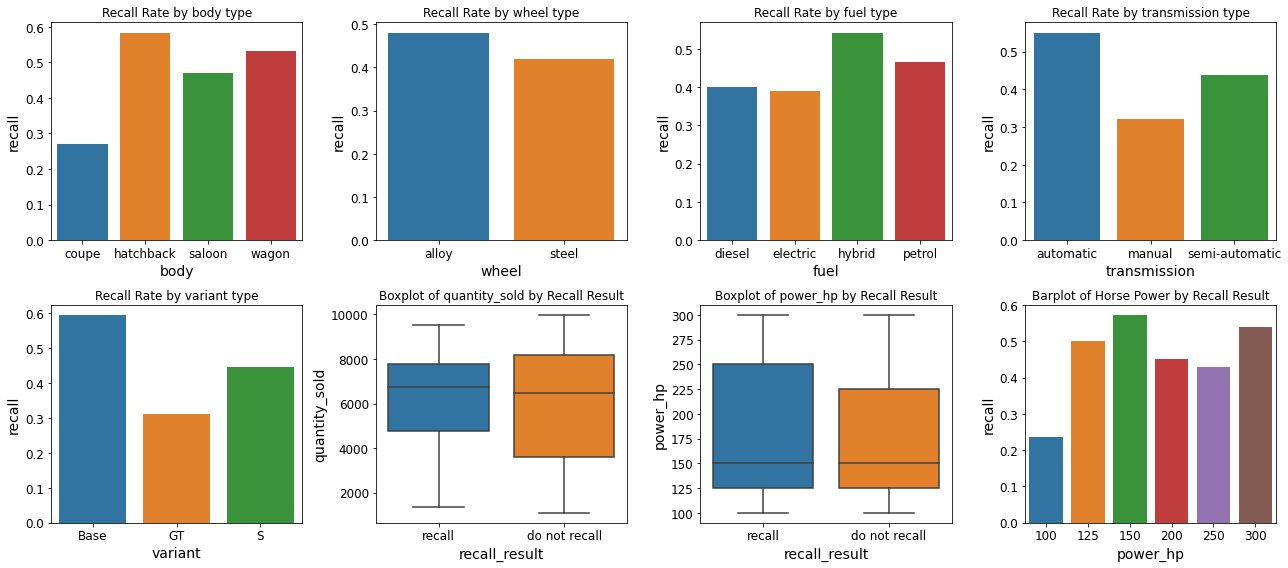

In [0]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for i, feature in enumerate(cat_features):

  grouping = car.groupby(feature)['recall_result'].value_counts(normalize=True).unstack()
  sns.barplot(x=grouping.index, y=grouping['recall'], ax=axes[i//4, i%4])
  axes[i//4, i%4].set(title='Recall Rate by ' + feature + ' type')

for i, feature in enumerate(num_features):
  sns.boxplot(x='recall_result', y=feature, data=car, ax=axes[1, i+1])
  axes[1, i+1].set(title='Boxplot of '+feature+' by Recall Result')

# treating horse power as categorical data
grouping = car.groupby('power_hp')['recall_result'].value_counts(normalize=True).unstack()
sns.barplot(x=grouping.index, y=grouping['recall'], ax=axes[1, 3])
axes[1, 3].set(title='Barplot of Horse Power by Recall Result')

plt.tight_layout(True)
plt.subplots_adjust(hspace=0.3)
save_fig('EDA_All_Features_with_Recall')

We can spot the similarities or differences of recall rate from each categorical feature. For example, the average recall rate is 60% in Base variant type of car, and is only 30% in GT variant type. Similarly, hybird car, hatchback car, alloy car and automatic car have the highest recall rate compared to other type in the same category.

In addition, cars with 150 horse power is 3 times more likely to be recalled than cars with 100 horse power. The advantage of visualisation is that it gives immediate insights of the data pattern with great interpretability. In general, I will move on to statistical test to validate insights, and identify the subtle differences of each level corresponding to target variable. But this step is not always necessary if the pattern is quite clear already. Feel free to skip below test to go to the predictive model section.

## Z test - Compare Recall Rate by Wheel Type

$H_0$: The average recall rate in alloy and wheel group is the same.

In [0]:
table = pd.crosstab(car['wheel'], car['recall_result'])
table

recall_result,do not recall,recall
wheel,,
alloy,26,24
steel,29,21


In [0]:
from statsmodels.stats.proportion import proportions_ztest

z_val, p_val = proportions_ztest(count=table['recall'], nobs=table.sum(axis=1), alternative='two-sided')

p_val

0.5464935954065822

P value is greater than .05. The data does not provide evidence to reject null hypothesis. We concluded the recall rate is the same in alloy and steel type.

## Chi Square Test

* Does any of the categorical variables have association with recall?
* If there's association, which level has significant impact on recall result?

In [0]:
from scipy.stats import chi2_contingency

def Create_Table(df, index_name, column_name):
  return pd.crosstab(df[index_name], df[column_name])

def Get_pval_chisq(contingency_table):
  _, pval, _, _ = chi2_contingency(contingency_table)
  return pval

pvals = {}

for col in ['power_hp','fuel', 'wheel', 'transmission', 'body', 'variant']:
  table = Create_Table(car, col, 'recall_result')
  pvals[col]=Get_pval_chisq(table)

chisq_result = pd.DataFrame.from_dict(pvals, orient='index').rename(columns={0:'chisq-pvalue'}).T.round(3)
chisq_result

,power_hp,fuel,wheel,transmission,body,variant
chisq-pvalue,0.459,0.703,0.688,0.173,0.159,0.077


Take significance level at 0.05, none of the variables show statistical significance in recall result.

Take significance level at 0.1, variant shows statistical significance to recall result. But which variant type has strong power in recall prediction? We will calculate the standard residusals to see where there is the most deviation from the expected values from chi-square test.



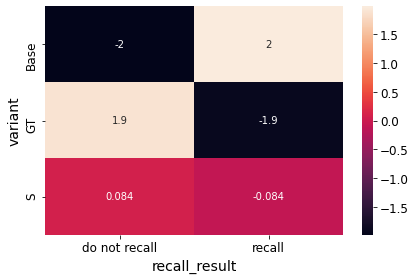

In [0]:
import statsmodels.api as sm

variant_table = Create_Table(car, 'variant', 'recall_result')
table = sm.stats.Table(variant_table)

sns.heatmap(table.standardized_resids, annot=True)
save_fig('Heatmap_of_Variant_Residuals_Chisq');


From the heatmap, we can easily see the biggest values are for the Base + recall, and GT + do not recall. S type is relatively similar in recall and not recall group.

## Bootstraping: the average quantity sold by recall group

<Figure size 432x288 with 0 Axes>

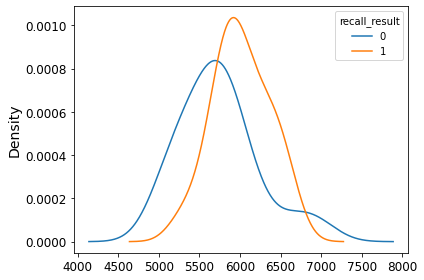

In [0]:
boot_recall = []
for i in range(20):
    boot_mean = car.sample(frac=1, replace=True).groupby('recall_result')['quantity_sold'].mean()
    boot_recall.append(boot_mean)

boot_recall = pd.DataFrame(boot_recall)
boot_recall.plot(kind='kde')
save_fig('bootstrap_diff_quantity_sold_by_recall_group')

These two distributions above show evidence of a difference in quantity sold in recall and not recall group. The average of 20 random samples show non-recalled vehicles were sold for 5500 on average, about 500 less than the recall vehicles sold.

## Time Series Visualisation on Recall Rate and Quantity Sold

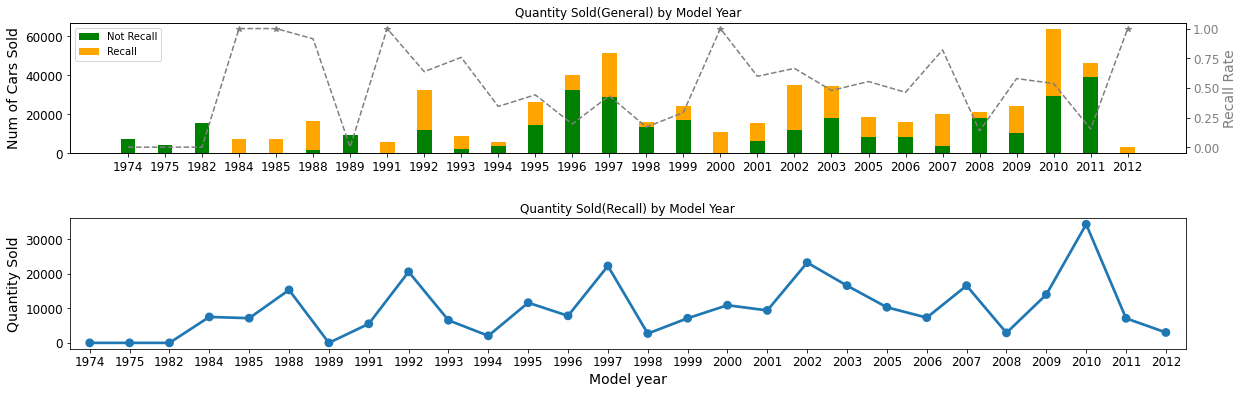

In [0]:
table = pd.pivot_table(car, index='model_year', columns='recall_result', values='quantity_sold', aggfunc=sum, fill_value=0)
x = list(range(0, len(table)))
m = table.sum(axis=1).values
y=table['do not recall'].values
z=table['recall'].values
r=table['recall'].div(table.sum(axis=1)).values

fig, (ax1, ax0) = plt.subplots(2, 1, figsize=(20, 6))

#first graph
bwidth=0.4

ax1.bar(x, y, width=bwidth, color='green', label='Not Recall')
ax1.bar(x, z, width=bwidth, bottom=y, color='orange', label='Recall')
ax1.set(ylabel='Num of Cars Sold')
ax1.set_xticks(x)
ax1.set_xticklabels(table.index.values)
ax1.legend(loc='upper left')

markers_on = np.where(r==1)[0].tolist()
color = 'tab:gray'
ax2 = ax1.twinx()
ax2.plot(x, r, '--', marker='*', color=color, markevery=markers_on)
ax2.set_ylabel('Recall Rate', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Quantity Sold(General) by Model Year')

#second graph
sns.pointplot(x=x, y=z, ax=ax0, legend=False)
ax0.set_xticks(x)
ax0.set_xticklabels(table.index.values)
ax0.set_title('Quantity Sold(Recall) by Model Year')
ax0.set_ylabel('Quantity Sold')
ax0.set_xlabel('Model year');

plt.subplots_adjust(hspace=0.5)
save_fig('Plots_Quantity_sold_and_Recall_by_Model_Year');

Firstly, car model made in year 1984, 1985, 1991, 2000, and 2012 had 100% recall rate. Conversely, car model made in 1974, 1975, 1982 had 100% not recall rate. This model year variable is a strong signal of recal prediction.

In addition. there appears to have repetitive pattern in recall quantity along with model year. Provided with panel data, we can conduct a time-series prediction, to use the historical data (such as last two or three years) to predict the recall quantity of new car model for the following years.



# Recall Analysis by Logistic Regression Model

Logistic regression is good benchmark model due to its simplicity and explainability. Above all, it provides quantitive interpretation between independent and target variables.

In [0]:
if car['recall_result'].dtype == 'object':
  car['recall_result'] = car['recall_result'].replace({'recall': 1, 'do not recall': 0})

model = smf.logit(formula='recall_result~quantity_sold+C(power_hp)+C(fuel)+C(transmission)+C(body)+C(variant)', data=car).fit() #drop the year to mitigate resultant df columns > rows
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.552105
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          recall_result   No. Observations:                  100
Model:                          Logit   Df Residuals:                       83
Method:                           MLE   Df Model:                           16
Date:                Sat, 23 May 2020   Pseudo R-squ.:                  0.1977
Time:                        18:51:29   Log-Likelihood:                -55.211
converged:                       True   LL-Null:                       -68.814
Covariance Type:            nonrobust   LLR p-value:                   0.03924
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.8157      1.036     -1

In [0]:
coeff = pd.DataFrame(model.params).rename(columns={0:'log_odds'})
exp_coef = np.exp(coeff)
prob_recall = exp_coef/(1+exp_coef)
coeff.assign(exp_coef=exp_coef, prob_recall=prob_recall)

,log_odds,exp_coef,prob_recall
Intercept,-1.815670,0.162729,0.139954
C(power_hp)[T.125],1.751507,5.763284,0.852143
C(power_hp)[T.150],2.009675,7.460892,0.881809
C(power_hp)[T.200],2.045025,7.729351,0.885444
C(power_hp)[T.250],1.847625,6.344735,0.863848
C(power_hp)[T.300],1.999368,7.384385,0.880731
C(fuel)[T.electric],-0.560650,0.570838,0.363397
C(fuel)[T.hybrid],1.024056,2.784467,0.735762
C(fuel)[T.petrol],0.218928,1.244742,0.554514
C(transmission)[T.manual],-1.256414,0.284673,0.221592


The model with LLR p-value less than 0.05 indicates the model is statistically significant. From the coefficient of fule variable, an eletric car is negatively related to recall, while a hybrid car is positively related to recall. We can tell from the coefficient of fule that when the car is hybrid, the log odds of them being recalled increased by 1.02. If we take the expopential of log odd, we will get the odd as 2.78, and probability that the car will be recalled will be 0.74, which means the use of hybrid fuel will increase 74% of chance of being recalled than diesel car.

The p value indicates the significance of the corresponding feature. Hence, we can use this for feature selection. The `horse power`, `body` and `variant` are statistically significant. We shall consider these features in predictive model.

# Recall Analysis by Decision Tree

Decision tree provides a good tool to visualize the combinatorial effects from multiple variables on target class.

In [0]:
cat_features = set(car.select_dtypes('object').columns).difference(['model_year'])
num_features = set(car.select_dtypes('int64').columns).difference(['recall_result', 'model_year'])

cat_enc = pd.get_dummies(car[cat_features])
car_encoded = pd.concat([cat_enc, car[num_features], car[['recall_result']]], axis=1)

X = car_encoded.drop('recall_result', axis=1)
y = car_encoded['recall_result']

In [0]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

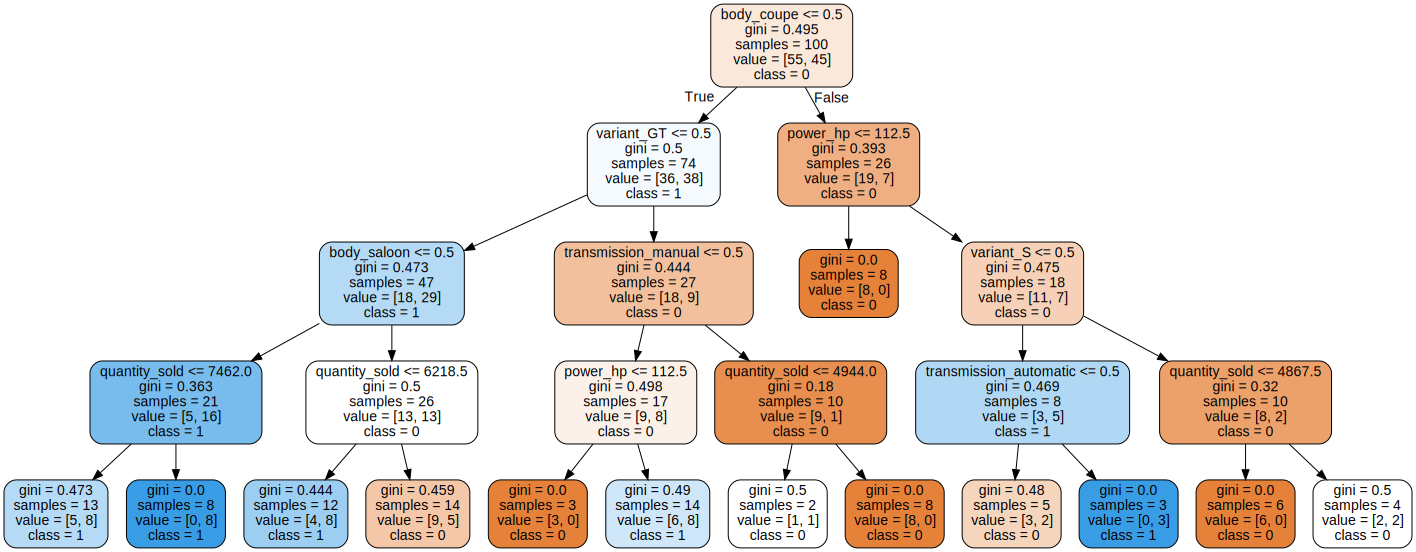

In [0]:
import graphviz
from sklearn.tree import export_graphviz

params = export_graphviz(
    tree, 
    feature_names=X.columns, 
    class_names=['0', '1'], 
    filled=True, 
    rounded=True, 
    out_file=None
) 

graph = graphviz.Source(params)
graph.format = 'png'
graph.render(os.path.join(IMAGES_PATH, 'dtree_render'),view=False)
graph

We can draw insights by following the tree in top-down manner. Blue color indicates class 1, orange indicates class 0. The deeper the color, the more pure or lower gini value calculated in the box.

The first split is `body as coupe`, with the threshold of 0.5. When vehicle type has `coupe` as its body, it is dummified as 1 in the dataset, therefore greater than threshold 0.5. In this case, the majority class is 0, meaning no recall as result, and we have a gini value of 0.495.

As gini is the impurity method, when the node is pure, that is having only one class, the gini value will be 0. We would like the gini to be lower, with sufficient cases in the node. Going to the right side of the tree, if `horse power` of the vehicle is also less than 112.5, this vehicle model is not going to be reclled. 

On the left side of the tree, there is a model type should be recalled following the trail of four different conditions:

> vehicle body is not coupe nor saloon -> variant is not GT -> manufacturer has sold more than 7462 cars in this type of vehicle -> this vehicle type should be recalled.

There are lots of insights we can draw from this diagram. You can also extend the trees or giving more attributes for it to evaluate. Decisiontree is better option than regression analysis when the data does not follow linear fashion.

# Build Machine Learning Models

## Preprocess

In [0]:
if car['recall_result'].dtype == 'object':
  car['recall_result'] = car['recall_result'].replace({'recall': 1, 'do not recall': 0})
  
car.head()

,model_year,fuel,wheel,power_hp,transmission,body,variant,quantity_sold,recall_result
0,2002,diesel,steel,100,semi-automatic,hatchback,Base,2641,1
1,2010,petrol,alloy,250,automatic,wagon,GT,1349,1
2,1992,diesel,steel,125,semi-automatic,saloon,S,7980,0
3,2010,petrol,alloy,250,semi-automatic,wagon,Base,1135,0
4,2005,diesel,steel,300,automatic,saloon,Base,2089,1


In [0]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

features = ['model_year', 'body', 'variant', 'power_hp']
X = car[features]
y = car['recall_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


#model year
encoder = TargetEncoder()
encoder.fit(X_train['model_year'].astype('object'), y_train)
year_enc_train = encoder.transform(X_train['model_year'].astype('object'))
year_enc_test = encoder.transform(X_test['model_year'].astype('object'))

#encode other cat vars
cat_vars = ['body', 'variant', 'power_hp']
ohe = OneHotEncoder()
ohe.fit(X_train[cat_vars])
cat_categories = ohe.categories_
train_cat = ohe.transform(X_train[cat_vars]).toarray()
test_cat = ohe.transform(X_test[cat_vars]).toarray()

X_train_cleaned = np.c_[year_enc_train, train_cat]
X_test_cleaned = np.c_[year_enc_test, test_cat]

## Benchmark: Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve

def get_CVScore(model, train_df, train_label, score_method=['roc_auc', 'f1', 'accuracy'], cv=3):
  model_scores = cross_validate(model, train_df, train_label, cv=cv,
                         scoring=score_method,
                         return_train_score=False)  
  avg_scores = {}
  for k in model_scores:
    if k.startswith('test'):
      avg_scores[k]=model_scores[k].mean().round(3)
  return avg_scores

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)
    plt.legend()

def get_roc_curve(model, train_df, train_label, method='predict_proba', cv=3):
  proba = cross_val_predict(model, train_df, train_label, method='predict_proba', cv=3)[:, 1]
  fpr_, tpr_, thesholds_ = roc_curve(train_label, proba)
  return fpr_, tpr_

{'test_roc_auc': 0.706, 'test_f1': 0.555, 'test_accuracy': 0.601}


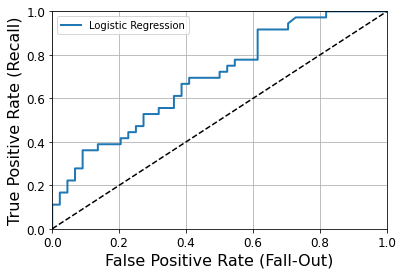

In [0]:
lg = LogisticRegression(random_state=42)
lg_scores = get_CVScore(lg, X_train_cleaned, y_train)
print(lg_scores)

lg_fpr, lg_tpr = get_roc_curve(lg, X_train_cleaned, y_train)
plot_roc_curve(lg_fpr, lg_tpr, label='Logistic Regression')
save_fig('ROC_AUC_LogisticRegresion_Benchmark')

## Train models

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

models = []
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Tree",DecisionTreeClassifier()))
models.append(("XGB",XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

scores = pd.DataFrame(data=lg_scores.values(), index=lg_scores.keys(), columns=['LG'])

for name,model in models:
  score = get_CVScore(model, X_train_cleaned, y_train)
  scores[name] = score.values()

scores

,LG,RF,SVC,Tree,XGB,KNN
test_roc_auc,0.706,0.673,0.636,0.646,0.696,0.677
test_f1,0.555,0.567,0.392,0.579,0.593,0.561
test_accuracy,0.601,0.638,0.538,0.650,0.637,0.651


## Model Performance

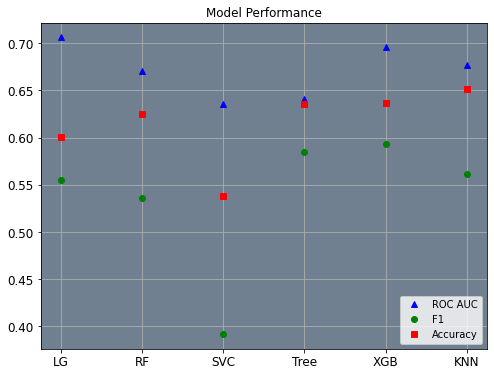

In [0]:
x_axis = range(6)
x_ticks = scores.columns

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_axis, scores.iloc[0, :], linestyle='None', marker='^', color='blue', label='ROC AUC')
ax.plot(x_axis, scores.iloc[1, :], linestyle='None', marker='o', color='green', label='F1')
ax.plot(x_axis, scores.iloc[2, :], linestyle='None', marker='s', color='red', label='Accuracy')
ax.set_xticks(x_axis)
ax.set_xticklabels(x_ticks)
ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Model Performance')
ax.set_facecolor('slategrey')
save_fig('Model_Performance_Post_Tuning')

Each model is cross validated 3 times. Logistic regression scores the highest AUC value, XGB scores the highest f1 value, and KNN gets the highest accuracy. SVC has the lowest performance score in all three measurements. We will retrain these three models, together with hyperparameter tuning.

## Hyperparameter Tuning

In [0]:
from sklearn.model_selection import GridSearchCV
import time


knn_param_grid = dict(n_neighbors = list(range(1, 5)), weights = ["uniform", "distance"])
lg_param_grid =dict(penalty=['l1', 'l2'], C=np.logspace(-4, 4, 20), solver=['liblinear'])
xgb_params_grid = dict(min_child_weight=[1, 5], 
                       gamma=[0.5, 1, 1.5, 2, 5],
                       subsample=[0.6, 0.8, 1.0],
                       colsample_bytree=[0.6, 0.8, 1.0],
                       max_depth=[2, 3, 4, 5])

metrics = ['roc_auc', 'f1', 'accuracy']

models = []
models.append(("LG",LogisticRegression(), lg_param_grid))
models.append(("XGB",XGBClassifier(), xgb_params_grid))
models.append(("KNN",KNeighborsClassifier(), knn_param_grid))

best = []
start = time.time()

for name, model, params in models:
  gridsearch = GridSearchCV(model, params, scoring=metrics, 
                          refit='roc_auc', return_train_score=False,cv =3)
  gridsearch.fit(X_train_cleaned, y_train)
  best.append((name, gridsearch.best_score_, gridsearch.best_estimator_))
  save_model(gridsearch.best_estimator_, name)

end = time.time()
duration = end - start
print('Duration: %.2f seconds'%duration)

Duration: 15.53 seconds


In [0]:
for (name, score, model) in best:
  print(name, score, model)

LG 0.771031746031746 LogisticRegression(C=78.47599703514607, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
XGB 0.7300264550264551 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
KNN 0.6951719576719576 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None,

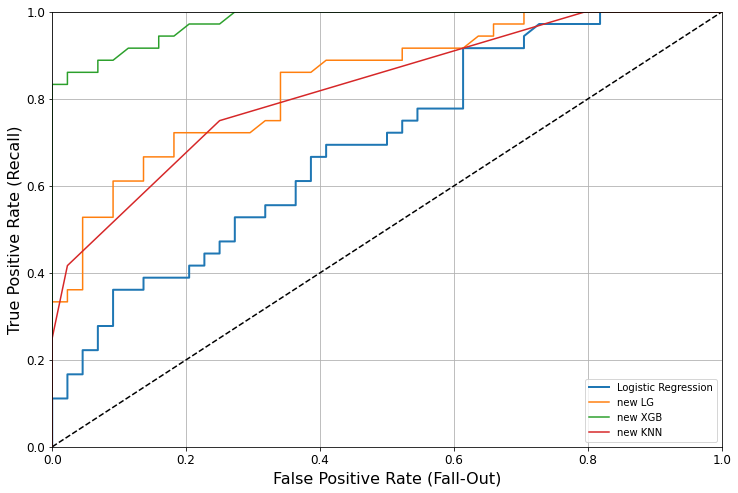

In [0]:
from sklearn.metrics import roc_auc_score, f1_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(lg_fpr, lg_tpr, linewidth=2, label='Logistic Regression')
ax.plot([0, 1], [0, 1], 'k--')
ax.axis([0, 1, 0, 1])                                    
ax.set_xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
ax.set_ylabel('True Positive Rate (Recall)', fontsize=16)    
ax.grid(True)

for (name, score, model) in best:

  proba_ = model.predict_proba(X_train_cleaned)[:, 1]
  y_train_preds = model.predict(X_train_cleaned)
  a, b, c = roc_auc_score(y_train, proba_), f1_score(y_train, y_train_preds), model.score(X_train_cleaned, y_train)
  scores['new_'+name] = [a, b, c]

  train_proba = model.predict_proba(X_train_cleaned)[:, 1]
  fpr, tpr, _ = roc_curve(y_train, train_proba)
  ax.plot(fpr, tpr, label='new '+name)

ax.legend(loc='lower right')
save_fig('ROC_AUC_Curve_From_Best_Models')

In [0]:
scores.round(3)

,LG,RF,SVC,Tree,XGB,KNN,new_LG,new_XGB,new_KNN
test_roc_auc,0.706,0.673,0.636,0.646,0.696,0.677,0.839,0.978,0.822
test_f1,0.555,0.567,0.392,0.579,0.593,0.561,0.706,0.912,0.577
test_accuracy,0.601,0.638,0.538,0.650,0.637,0.651,0.750,0.925,0.725


The new tuned model outformed the benchmark model (untuned logistic regression). The strongest learner is XGB, followed by tuned Logistic Regression and KNN. The performance is actually quite high, it appears to be overfitting the training data. We will need to use test data to evaluate the realistic performance.

## Predict on unseen data Using Merged Model

In [0]:
weights = [1, 4, 1]

final_test = pd.DataFrame(y_test)
for name, _, model in best:
  final_test[name] = model.predict_proba(X_test_cleaned)[:, 1]

final_test['weighted_mean'] = (final_test.iloc[:, 1:]*weights).sum(axis=1)/sum(weights)
final_test['Prediction'] = final_test['weighted_mean'].round(0)
final_test

,recall_result,LG,XGB,KNN,weighted_mean,Prediction
83,1,0.047072,0.074787,0.00,0.057703,0.0
53,0,0.965037,0.964610,0.50,0.887246,1.0
70,0,0.083501,0.185882,0.25,0.179505,0.0
45,1,0.376554,0.853836,0.75,0.756983,1.0
44,0,0.032837,0.140364,0.00,0.099049,0.0
39,1,0.008645,0.177569,0.75,0.244820,0.0
22,0,0.891363,0.804671,0.50,0.768341,1.0
80,0,0.034546,0.144258,0.00,0.101930,0.0
10,0,0.122214,0.466039,0.75,0.456061,0.0
0,1,0.864382,0.912389,0.25,0.793989,1.0


## Results

In [0]:
from sklearn.metrics import classification_report

print(classification_report(probability['recall_result'], probability['Prediction']))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



Our final model is tested by 20 samples, 9 of which is positive labled. Our model correctly classify 67% of all the recalled models. It also correctly classify 70% of the non-recalled class. The overall accuracy of the model is 65%. In the original dataset, recall occupied 45% of the entire dataset, and not recall occupied 55%. By random guessing, we will be right for about 50% of the time. Our model has outformed random guessing by 15% differences. It will be a good start to continue feed in more data to build a robust model. 

**The end of test**